In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 5

env: CUDA_VISIBLE_DEVICES=5


In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd

from batchflow import Pipeline, B, V, I, M, C, Notifier, plot
from batchflow.models.torch import TorchModel, VGGBlock

from loader import ImagesDataset
from plotter import plot_notifier_curve

In [3]:
seed = 11
rng = np.random.default_rng(seed)

In [4]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=seed)

100%|█████████████████████████████████████████████| 9/9 [00:17<00:00,  1.98s/it]


In [6]:
MODEL_CONFIG = {
    # Model architecture
    'body': {
        'type': 'encoder',
        'output_type': 'tensor',
        'order': ['block', 'downsampling'],
        'num_stages': 3,
        'blocks': {
            'base_block': VGGBlock,
            'channels': [64, 128, 256],
            'depth3': 2,
            'depth1': [0, 0, 1],
        },
    },

    'head': {
        'layout': 'Vdf',
        'dropout_rate': 0.4,
        'classes': n_classes
    },

    'common/conv/bias' : False,

    # Model training details:
    'loss': 'ce',
    'optimizer': 'Adam',
    'output': {'predicted': ['proba', 'labels']},
}

In [7]:
def evaluate_metrics(iteration, frequency, template, model, metrics):
    if (iteration - 1) % frequency == 0:
        
        test_pipeline = test_template << dataset.test << {'model': model}
        test_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False)
        
        metrics_values = []
        for metric_name, metric_config in metrics.items():
            metric_value = test_pipeline.v('metrics').evaluate(metric_name, **metric_config)
            metrics_values.append([metric_value])

        return metrics_values
    return [[],[],[]]


train_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)
    
    # initialize loss and metrics containers
    .init_variable(name='loss_history', default=[])
    .init_variable(name='accuracy', default=[])
    .init_variable(name='precision', default=[[np.nan] * n_classes])
    .init_variable(name='recall', default=[[np.nan] * n_classes])
    
    # initialize model to train
    .init_model(name='model', model_class=TorchModel, mode='dynamic', config=MODEL_CONFIG)
    
    # launch train itself
    .train_model(name='model', inputs=B('images'), targets=B('labels'),
                 outputs='loss', save_to=V('loss_history', mode='a'))
    
    # evaluate model
    .call(evaluate_metrics, iteration=I(), template=C('evaluate/template'), model=M('model'),
          frequency=C('evaluate/frequency'), metrics=C('evaluate/metrics'),
          save_to=[V('accuracy', mode='e'), V('precision', mode='e'), V('recall', mode='e')])
)

test_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)

    # initialize prediction and metrics containers
    .init_variables('proba', 'predictions', 'metrics')
    
    # import trained model
    .import_model('model', C('model'))
    
    # make predictions
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predicted_proba', 'predictions'],
                   save_to=[V('proba'), V('predictions')])
    
    # accumulate predictions in confusion matrix
    .gather_metrics('classification', targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', num_classes=n_classes,
                    axis=1, save_to=V('metrics', mode='update'))
)

TEST_FREQUENCY = 250

train_config = {
    'evaluate' : {
        'template': test_template,
        'frequency': TEST_FREQUENCY,
        'metrics': {
            'accuracy': {},
            'precision': {'multiclass': None},
            'recall': {'multiclass': None},
        }
    }
}

train_pipeline = train_template << dataset.train << train_config

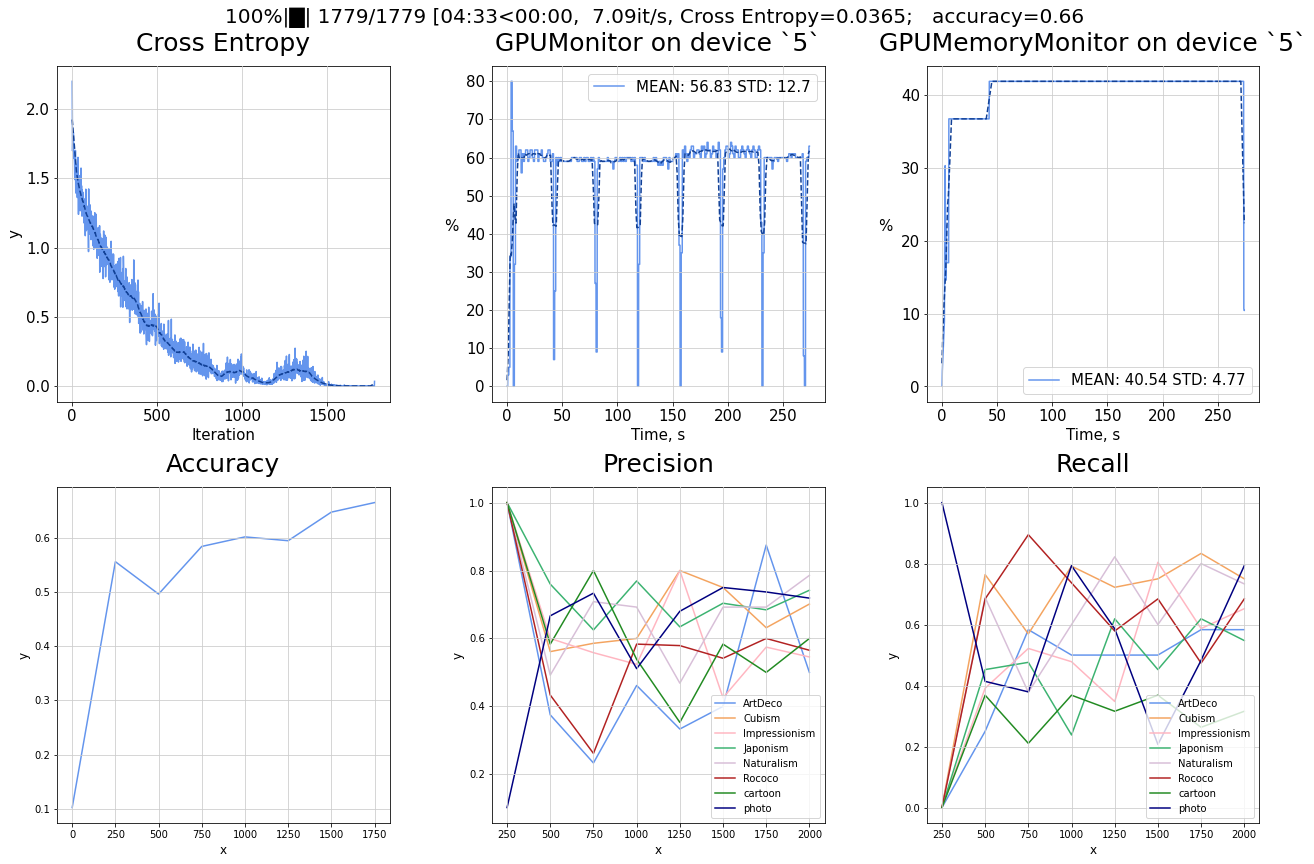

In [8]:
notifier = Notifier(**{
    'frequency': TEST_FREQUENCY,
    'graphs': [
        {
            'source': 'loss_history',
            'name': 'Cross Entropy',
        },
        'gpu',
        'gpu_memory',
        {
            'source': 'accuracy',
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'title': 'Accuracy',
                'frequency': TEST_FREQUENCY
            }
        },
        {
            'source': train_pipeline.v('precision'),
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'label': list(dataset.label_encoder.classes_),
                'legend_size': 10,
                'title': 'Precision',
                'frequency': TEST_FREQUENCY
            },
        },
        {
            'source': train_pipeline.v('recall'),
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'label': list(dataset.label_encoder.classes_),
                'legend_size': 10,
                'title': 'Recall',
                'frequency': TEST_FREQUENCY
            },
        }
    ],
    'plot_config': {
        'ncols': 3, 'nrows': 2
    }
})

BATCH_SIZE = 128
N_EPOCHS = 200

_ = train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, shuffle=True, notifier=notifier)

In [16]:
MODEL_PATH = '../models/vgg.torch'
model = train_pipeline.model
# model.save(MODEL_PATH)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


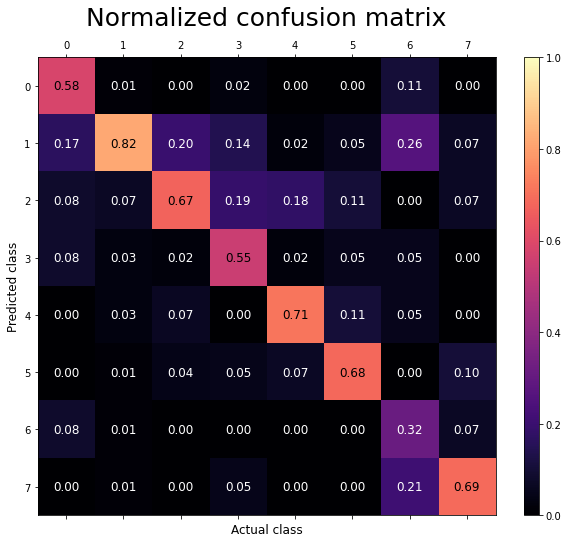

In [13]:
test_pipeline = test_template << dataset.test << {'model': model}
test_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False, bar='t')

metrics = test_pipeline.v('metrics')
metrics.plot_confusion_matrix(normalize=True, vmin=0, vmax=1)

In [15]:
labels, counts = np.unique(dataset.labels[dataset.test.indices], return_counts=True)
shares = counts / counts.sum()

metrics_names = ['precision', 'recall']
metrics_dict = metrics.evaluate(metrics_names, multiclass=None)
metrics_df = pd.DataFrame({'names': dataset.label_encoder.classes_, 'counts': counts, 'shares': shares, **metrics_dict})

formatter = lambda value: f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics_names).format(formatter, subset=['shares', *metrics_names])

,names,counts,shares,precision,recall
0,ArtDeco,12,4%,63%,58%
1,Cubism,72,25%,69%,81%
2,Impressionism,46,16%,54%,67%
3,Japonism,42,14%,76%,54%
4,Naturalism,45,15%,80%,71%
5,Rococo,19,6%,54%,68%
6,cartoon,19,6%,60%,31%
7,photo,29,10%,74%,68%


In [14]:
metrics_names = ['accuracy', 'f1_score']
metrics_values = [metrics.evaluate(metric_name) for metric_name in metrics_names]

metrics_df = pd.DataFrame(data=metrics_values, index=metrics_names)
metrics_df.T.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)

,accuracy,f1_score
0,67%,64%


In [18]:
METRICS_PATH = '../metrics/vgg.npy'
all_metrics = {**metrics_dict, **{key: value for key, value in zip(metrics_names, metrics_values)}}
np.save(METRICS_PATH, all_metrics)